In [49]:
import pandas as pandas
import yfinance as yf
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import precision_score

In [50]:
stock = yf.Ticker("^GSPC")

In [51]:
stock = stock.history(period="max")

In [52]:
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-04 00:00:00-04:00,5278.240234,5298.799805,5257.629883,5291.339844,3707900000,0.0,0.0
2024-06-05 00:00:00-04:00,5314.479980,5354.160156,5297.640137,5354.029785,3591460000,0.0,0.0
2024-06-06 00:00:00-04:00,5357.799805,5362.350098,5335.359863,5352.959961,3609990000,0.0,0.0


<Axes: xlabel='Date'>

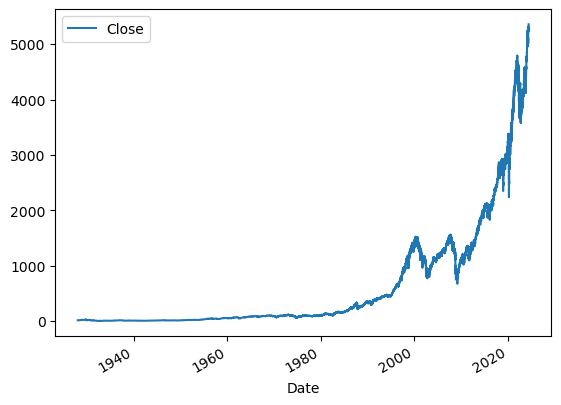

In [53]:
stock.plot.line(y="Close", use_index = True)

In [54]:
del stock["Dividends"]
del stock["Stock Splits"]

In [55]:
stock["tomorrow"] = stock["Close"].shift(-1)


In [56]:
stock["predict"] = (stock["tomorrow"] > stock["Close"]).astype(int)

In [60]:
sp500 = stock.loc["1995-01-01":].copy()
sp500

,Open,High,Low,Close,Volume,tomorrow,predict
Date,,,,,,,
1995-01-03 00:00:00-05:00,459.209991,459.269989,457.200012,459.109985,262450000,460.709991,1
1995-01-04 00:00:00-05:00,459.130005,460.720001,457.559998,460.709991,319510000,460.339996,0
1995-01-05 00:00:00-05:00,460.730011,461.299988,459.750000,460.339996,309050000,460.679993,1
1995-01-06 00:00:00-05:00,460.380005,462.489990,459.470001,460.679993,308070000,460.829987,1
1995-01-09 00:00:00-05:00,460.670013,461.769989,459.739990,460.829987,278790000,461.679993,1
...,...,...,...,...,...,...,...
2024-06-04 00:00:00-04:00,5278.240234,5298.799805,5257.629883,5291.339844,3707900000,5354.029785,1
2024-06-05 00:00:00-04:00,5314.479980,5354.160156,5297.640137,5354.029785,3591460000,5352.959961,0
2024-06-06 00:00:00-04:00,5357.799805,5362.350098,5335.359863,5352.959961,3609990000,5346.990234,0


In [61]:
model = RandomForestClassifier(n_estimators=250, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictor = ["Close", "Volume", "Low", "High", "Open"]
model.fit(train[predictor], train["predict"])

RandomForestClassifier(min_samples_split=100, n_estimators=250, random_state=1)

In [66]:
def predict(train, test, predictor, model):
    model.fit(train[predictor], train["predict"])
    prediction = model.predict(test[predictor])
    prediction = pandas.Series(prediction, index = test.index, name = "predictions")
    combine = pandas.concat([test["predict"], prediction], axis=1)
    return combine

In [70]:
def backtest(data, model, predictor, start = 2000, step = 200):
    all_prediction = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        prediction = predict(train, test, predictor, model)
        all_prediction.append(prediction)
    return pandas.concat(all_prediction)

In [73]:
prediction = backtest(sp500,model,predictor)
prediction

,predict,predictions
Date,,
2002-12-10 00:00:00-05:00,1,1
2002-12-11 00:00:00-05:00,0,0
2002-12-12 00:00:00-05:00,0,0
2002-12-13 00:00:00-05:00,1,1
2002-12-16 00:00:00-05:00,0,0
...,...,...
2024-06-04 00:00:00-04:00,1,0
2024-06-05 00:00:00-04:00,0,0
2024-06-06 00:00:00-04:00,0,0


In [74]:
prediction["predict"]
prediction["predictions"]
precision_score(prediction["predict"], prediction["predictions"])


0.5367647058823529

In [75]:
horizon = [2,5,60,250,1000]
new_predictors = []
for horizon in horizon:
    rolling_ave = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_ave["Close"]
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["predict"]
    new_predictors += [ratio_column,trend_column]
sp500

,Open,High,Low,Close,Volume,tomorrow,predict,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1995-01-03 00:00:00-05:00,459.209991,459.269989,457.200012,459.109985,262450000,460.709991,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-04 00:00:00-05:00,459.130005,460.720001,457.559998,460.709991,319510000,460.339996,0,1.001739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-05 00:00:00-05:00,460.730011,461.299988,459.750000,460.339996,309050000,460.679993,1,0.999598,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-06 00:00:00-05:00,460.380005,462.489990,459.470001,460.679993,308070000,460.829987,1,1.000369,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-09 00:00:00-05:00,460.670013,461.769989,459.739990,460.829987,278790000,461.679993,1,1.000163,2.0,1.001077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-04 00:00:00-04:00,5278.240234,5298.799805,5257.629883,5291.339844,3707900000,5354.029785,1,1.000751,2.0,1.003871,3.0,1.021154,32.0,1.121890,140.0,1.260941,531.0
2024-06-05 00:00:00-04:00,5314.479980,5354.160156,5297.640137,5354.029785,3591460000,5352.959961,0,1.005889,2.0,1.012419,4.0,1.032468,33.0,1.134136,141.0,1.275185,531.0
2024-06-06 00:00:00-04:00,5357.799805,5362.350098,5335.359863,5352.959961,3609990000,5346.990234,0,0.999900,1.0,1.007740,4.0,1.031673,32.0,1.132893,140.0,1.274254,530.0


In [76]:
model2 = RandomForestClassifier(n_estimators=350, min_samples_split=50, random_state=1)


In [78]:
def predict2(train, test, predictor, model):
    model2.fit(train[predictor], train["predict"])
    prediction = model2.predict_proba(test[predictor])[:,1]
    prediction[prediction >= .6] = 1
    prediction[prediction < .6] = 0
    prediction = pandas.Series(prediction, index = test.index, name = "predictions")
    combine = pandas.concat([test["predict"], prediction], axis=1)
    return combine

In [83]:
prediction2 = backtest(sp500,model2,predictor)
prediction2

,predict,predictions
Date,,
2002-12-10 00:00:00-05:00,1,1
2002-12-11 00:00:00-05:00,0,0
2002-12-12 00:00:00-05:00,0,0
2002-12-13 00:00:00-05:00,1,1
2002-12-16 00:00:00-05:00,0,0
...,...,...
2024-06-04 00:00:00-04:00,1,0
2024-06-05 00:00:00-04:00,0,0
2024-06-06 00:00:00-04:00,0,0


In [84]:
prediction2["predict"]
prediction2["predictions"]
precision_score(prediction2["predict"], prediction2["predictions"])

0.5363869863013698